<a href="https://colab.research.google.com/github/SAURABHMOHARIR/Android-Apps/blob/master/GWP1_Derivative_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Convergence table (American CALL prices):


,K,Call_N50,Call_N100,Call_N200,Call_N200_rounded
0,90,11.671092,11.671660,11.670904,11.67
1,95,7.721590,7.717614,7.714026,7.71
2,100,4.605026,4.610008,4.612502,4.61
3,105,2.485786,2.481895,2.477242,2.48
4,110,1.191720,1.191764,1.192232,1.19



Final table (N=200) — American vs European (BS):


,K,American_Call_N200,European_Call_BS,Call_diff(Amer-Eur)
0,90,11.67,11.67,0.000817
1,95,7.71,7.71,-0.000344
2,100,4.61,4.61,-0.002495
3,105,2.48,2.48,-0.000660
4,110,1.19,1.19,0.001101



Saved: q17_convergence_calls.csv, q17_final_calls.csv


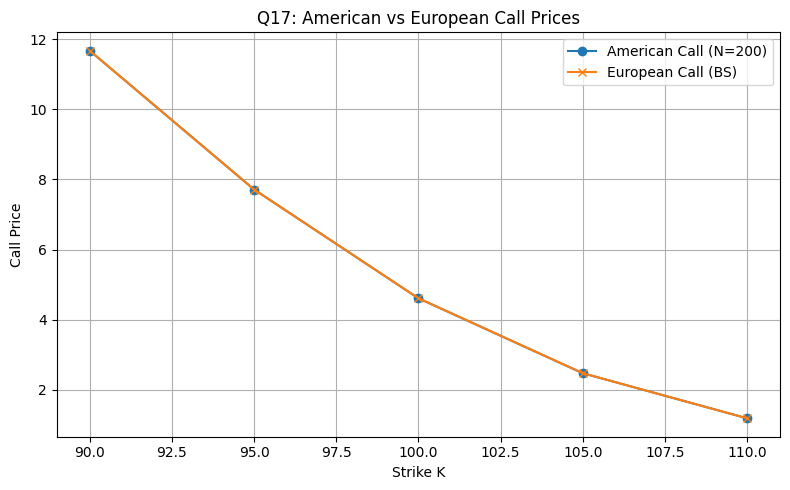

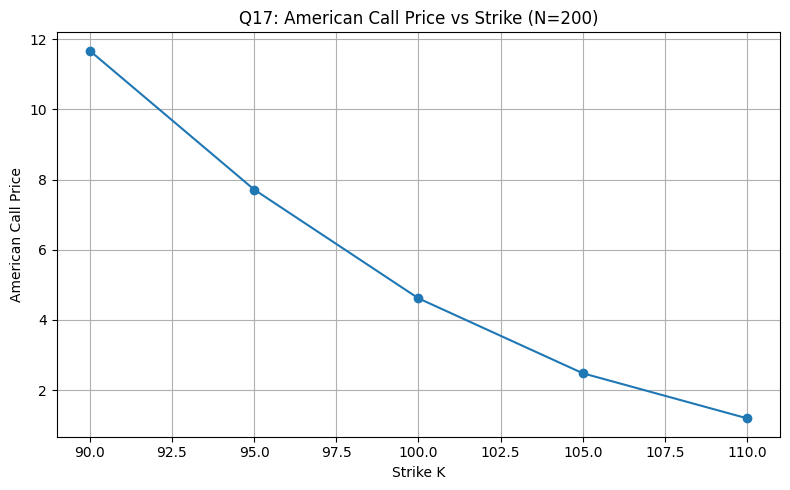

Saved plot PNGs: q17_call_vs_strike.png, q17_american_calls.png

Suggested 2-3 line comment for Q17 (paste into assignment):
Using a symmetric trinomial tree (u = exp(sigma*sqrt(2*dt))) with Hull/Boyle-style probabilities and N=200 steps,
the American call prices for K = [90, 95, 100, 105, 110] are [11.67, 7.71, 4.61, 2.48, 1.19] (rounded). Observed: American calls ≈ European calls (no dividend), so early exercise is not optimal.


In [1]:
# Q17: Trinomial tree - American CALL pricing (Google Colab ready)

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from math import erf, sqrt, exp, log

# --------------------------
# Utility: Black-Scholes (European) for comparison
# --------------------------
def normal_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def bs_price(S, K, r, sigma, T, option='call'):
    if T <= 0:
        return max(S - K, 0.0) if option == 'call' else max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    if option == 'call':
        return S * normal_cdf(d1) - K * math.exp(-r * T) * normal_cdf(d2)
    else:
        return K * math.exp(-r * T) * normal_cdf(-d2) - S * normal_cdf(-d1)

# --------------------------
# Main: American trinomial pricing function (symmetric trinomial variant)
# --------------------------
def american_trinomial_call(S0, K, r, sigma, T, N, q=0.0):
    """
    Prices an American CALL using a symmetric trinomial tree (Hull/Boyle style).
    Parameters:
      S0: initial stock price
      K: strike
      r: risk-free rate (continuous)
      sigma: volatility (annual)
      T: time to maturity (years)
      N: number of time steps
      q: continuous dividend yield (default 0.0)
    Returns:
      option_price (float)
    """
    dt = T / N
    if dt <= 0:
        return max(S0 - K, 0.0)

    # symmetric factors
    u = math.exp(sigma * math.sqrt(2.0 * dt))
    d = 1.0 / u

    # risk-neutral probability parameters (adjust drift by r - q)
    a = math.exp((r - q) * dt / 2.0)
    b = math.exp(sigma * math.sqrt(dt / 2.0))
    c = math.exp(-sigma * math.sqrt(dt / 2.0))
    denom = (b - c)
    if abs(denom) < 1e-16:
        p_u = p_d = 0.0
        p_m = 1.0
    else:
        p_u = ((a - c) / denom)**2
        p_d = ((b - a) / denom)**2
        p_m = 1.0 - p_u - p_d

    disc = math.exp(-r * dt)

    # Terminal layer: j = -N .. +N
    j = np.arange(-N, N+1)
    S_T = S0 * (u ** j)
    V = np.maximum(S_T - K, 0.0)  # Call payoff at maturity

    # Backward induction
    # V is currently array of length 2N+1 representing nodes j=-N..+N
    for i in range(N-1, -1, -1):
        # Continuation values computed from V entries corresponding to level i+1
        # For level i there are 2*i+1 nodes; V_next has 2*(i+1)+1
        V_cont = disc * (p_u * V[2:2+2*i+1] + p_m * V[1:1+2*i+1] + p_d * V[0:0+2*i+1])
        # Intrinsic at level i
        j_i = np.arange(-i, i+1)
        S_i = S0 * (u ** j_i)
        V_intr = np.maximum(S_i - K, 0.0)
        # American option = max(intrinsic, continuation)
        V = np.maximum(V_intr, V_cont)

    # Now V has length 1
    return float(V[0])

# --------------------------
# Parameters (edit here if needed)
# --------------------------
S0 = 100.0
r = 0.05         # continuous risk-free rate
sigma = 0.20     # volatility
T = 0.25         # maturity in years (3 months)
K_list = [90, 95, 100, 105, 110]
Ns = [50, 100, 200]   # for convergence check
q = 0.0               # dividend yield (0 for Q17: non-dividend stock)

# --------------------------
# Convergence table (N = 50,100,200)
# --------------------------
conv_rows = []
for K in K_list:
    row = {'K': K}
    for N in Ns:
        price = american_trinomial_call(S0, K, r, sigma, T, N, q=q)
        row[f'Call_N{N}'] = round(price, 6)
    # best estimate rounded for report (N=200)
    row['Call_N200_rounded'] = round(row[f'Call_N{Ns[-1]}'], 2)
    conv_rows.append(row)

conv_df = pd.DataFrame(conv_rows)
print("Convergence table (American CALL prices):")
display(conv_df)

# --------------------------
# Final table vs Black-Scholes European call (N=200)
# --------------------------
final_rows = []
for K in K_list:
    amer = american_trinomial_call(S0, K, r, sigma, T, Ns[-1], q=q)
    euro = bs_price(S0, K, r, sigma, T, option='call')
    final_rows.append({
        'K': K,
        'American_Call_N200': round(amer, 2),
        'European_Call_BS': round(euro, 2),
        'Call_diff(Amer-Eur)': round(amer - euro, 6)
    })
final_df = pd.DataFrame(final_rows)
print("\nFinal table (N=200) — American vs European (BS):")
display(final_df)

# Save CSVs
conv_df.to_csv('q17_convergence_calls.csv', index=False)
final_df.to_csv('q17_final_calls.csv', index=False)
print("\nSaved: q17_convergence_calls.csv, q17_final_calls.csv")

# --------------------------
# Plots: American Call Price vs Strike (and comparison with BS)
# --------------------------
calls_amer = [american_trinomial_call(S0, K, r, sigma, T, Ns[-1], q=q) for K in K_list]
calls_bs = [bs_price(S0, K, r, sigma, T, 'call') for K in K_list]

plt.figure(figsize=(8,5))
plt.plot(K_list, calls_amer, marker='o', label='American Call (N=200)')
plt.plot(K_list, calls_bs, marker='x', label='European Call (BS)')
plt.title('Q17: American vs European Call Prices')
plt.xlabel('Strike K')
plt.ylabel('Call Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('q17_call_vs_strike.png', dpi=200)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(K_list, calls_amer, marker='o')
plt.title('Q17: American Call Price vs Strike (N=200)')
plt.xlabel('Strike K')
plt.ylabel('American Call Price')
plt.grid(True)
plt.tight_layout()
plt.savefig('q17_american_calls.png', dpi=200)
plt.show()

print("Saved plot PNGs: q17_call_vs_strike.png, q17_american_calls.png")

# --------------------------
# Short automatic commentary to paste into assignment (2-3 lines)
# --------------------------
print("\nSuggested 2-3 line comment for Q17 (paste into assignment):")
print("Using a symmetric trinomial tree (u = exp(sigma*sqrt(2*dt))) with Hull/Boyle-style probabilities and N=200 steps,")
print("the American call prices for K = {} are {} (rounded). Observed: American calls ≈ European calls (no dividend), so early exercise is not optimal.".format(
    K_list, [round(x,2) for x in calls_amer]
))


Convergence table (American PUT prices):


,K,Put_N50,Put_N100,Put_N200,Put_N200_rounded
0,90,0.563381,0.564318,0.563688,0.56
1,95,1.578875,1.575457,1.572110,1.57
2,100,3.472120,3.476131,3.478026,3.48
3,105,6.428559,6.426073,6.422828,6.42
4,110,10.328957,10.329855,10.330519,10.33



Final table (N=200) — American vs European (BS):


,K,American_Put_N200,European_Put_BS,Put_diff(Amer-Eur)
0,90,0.56,0.55,0.011599
1,95,1.57,1.53,0.037850
2,100,3.48,3.37,0.105249
3,105,6.42,6.17,0.249257
4,110,10.33,9.82,0.505829



Saved: q18_convergence_puts.csv, q18_final_puts.csv


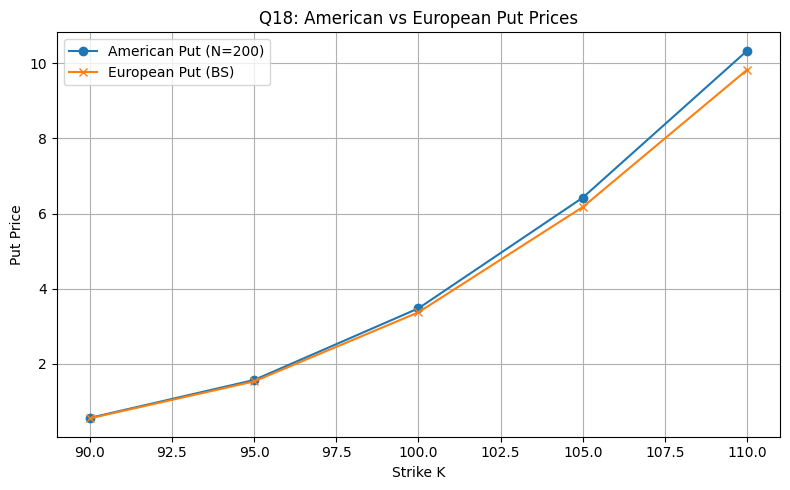

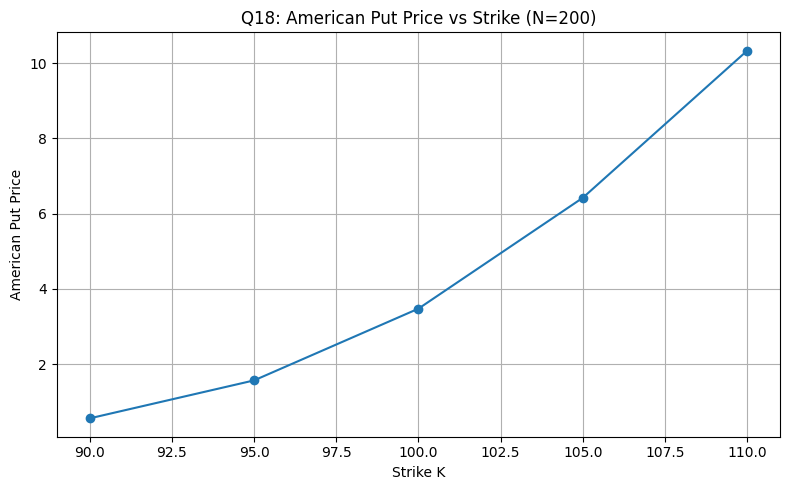

Saved plot PNGs: q18_put_vs_strike.png, q18_american_puts.png

Suggested 2-3 line comment for Q18 (paste into assignment):
Using a symmetric trinomial tree (u = exp(sigma*sqrt(2*dt))) with Hull/Boyle-style probabilities and N=200 steps,
the American put prices for K = [90, 95, 100, 105, 110] are [0.56, 1.57, 3.48, 6.42, 10.33] (rounded). Observed: American puts >= European puts (early exercise can be optimal).


In [2]:
# Q18: Trinomial tree - American PUT pricing (Google Colab / Jupyter ready)


import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# --------------------------
# Black-Scholes for comparison (European)
# --------------------------
def normal_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def bs_price(S, K, r, sigma, T, option='put'):
    if T <= 0:
        return max(K - S, 0.0) if option == 'put' else max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    if option == 'call':
        return S * normal_cdf(d1) - K * math.exp(-r * T) * normal_cdf(d2)
    else:
        return K * math.exp(-r * T) * normal_cdf(-d2) - S * normal_cdf(-d1)

# --------------------------
# Trinomial pricing function (handles put/call)
# --------------------------
def american_trinomial(S0, K, r, sigma, T, N, option_type='put', q=0.0):
    """
    Prices an American option (put or call) using symmetric trinomial tree (Hull/Boyle).
    S0: initial stock price
    K: strike
    r: continuous risk-free rate
    sigma: volatility (annual)
    T: time to maturity (years)
    N: number of steps
    option_type: 'put' or 'call'
    q: continuous dividend yield (default 0.0)
    """
    dt = T / N
    if dt <= 0:
        if option_type == 'put':
            return max(K - S0, 0.0)
        else:
            return max(S0 - K, 0.0)

    u = math.exp(sigma * math.sqrt(2.0 * dt))
    d = 1.0 / u

    a = math.exp((r - q) * dt / 2.0)
    b = math.exp(sigma * math.sqrt(dt / 2.0))
    c = math.exp(-sigma * math.sqrt(dt / 2.0))
    denom = (b - c)
    if abs(denom) < 1e-16:
        p_u = p_d = 0.0
        p_m = 1.0
    else:
        p_u = ((a - c) / denom)**2
        p_d = ((b - a) / denom)**2
        p_m = 1.0 - p_u - p_d

    disc = math.exp(-r * dt)

    j = np.arange(-N, N+1)
    S_T = S0 * (u ** j)
    if option_type == 'call':
        V = np.maximum(S_T - K, 0.0)
    else:
        V = np.maximum(K - S_T, 0.0)

    for i in range(N-1, -1, -1):
        V_cont = disc * (p_u * V[2:2+2*i+1] + p_m * V[1:1+2*i+1] + p_d * V[0:0+2*i+1])
        j_i = np.arange(-i, i+1)
        S_i = S0 * (u ** j_i)
        if option_type == 'call':
            V_intr = np.maximum(S_i - K, 0.0)
        else:
            V_intr = np.maximum(K - S_i, 0.0)
        V = np.maximum(V_intr, V_cont)

    return float(np.round(V[0], 6))


# --------------------------
# Parameters (edit if needed)
# --------------------------
S0 = 100.0
r = 0.05
sigma = 0.20
T = 0.25              # 3 months
K_list = [90, 95, 100, 105, 110]
Ns = [50, 100, 200]   # convergence steps
q = 0.0               # continuous dividend yield (0 for non-dividend)

# --------------------------
# Convergence table (American PUT)
# --------------------------
conv_rows = []
for K in K_list:
    row = {'K': K}
    for N in Ns:
        price = american_trinomial(S0, K, r, sigma, T, N, option_type='put', q=q)
        row[f'Put_N{N}'] = price
    row['Put_N200_rounded'] = round(row[f'Put_N{Ns[-1]}'], 2)
    conv_rows.append(row)

conv_df = pd.DataFrame(conv_rows)
print("Convergence table (American PUT prices):")
display(conv_df)

# --------------------------
# Final table vs Black-Scholes European put (N=200)
# --------------------------
final_rows = []
for K in K_list:
    amer = american_trinomial(S0, K, r, sigma, T, Ns[-1], option_type='put', q=q)
    euro = bs_price(S0, K, r, sigma, T, option='put')
    final_rows.append({
        'K': K,
        'American_Put_N200': round(amer, 2),
        'European_Put_BS': round(euro, 2),
        'Put_diff(Amer-Eur)': round(amer - euro, 6)
    })

final_df = pd.DataFrame(final_rows)
print("\nFinal table (N=200) — American vs European (BS):")
display(final_df)

# Save CSVs
conv_df.to_csv('q18_convergence_puts.csv', index=False)
final_df.to_csv('q18_final_puts.csv', index=False)
print("\nSaved: q18_convergence_puts.csv, q18_final_puts.csv")

# --------------------------
# Plots: American Put Price vs Strike and overlay with European (BS)
# --------------------------
puts_amer = [american_trinomial(S0, K, r, sigma, T, Ns[-1], option_type='put', q=q) for K in K_list]
puts_bs = [bs_price(S0, K, r, sigma, T, 'put') for K in K_list]

plt.figure(figsize=(8,5))
plt.plot(K_list, puts_amer, marker='o', label='American Put (N=200)')
plt.plot(K_list, puts_bs, marker='x', label='European Put (BS)')
plt.title('Q18: American vs European Put Prices')
plt.xlabel('Strike K')
plt.ylabel('Put Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('q18_put_vs_strike.png', dpi=200)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(K_list, puts_amer, marker='o')
plt.title('Q18: American Put Price vs Strike (N=200)')
plt.xlabel('Strike K')
plt.ylabel('American Put Price')
plt.grid(True)
plt.tight_layout()
plt.savefig('q18_american_puts.png', dpi=200)
plt.show()

print("Saved plot PNGs: q18_put_vs_strike.png, q18_american_puts.png")

# --------------------------
# Short automatic commentary (2-3 lines) for assignment paste
# --------------------------
print("\nSuggested 2-3 line comment for Q18 (paste into assignment):")
print("Using a symmetric trinomial tree (u = exp(sigma*sqrt(2*dt))) with Hull/Boyle-style probabilities and N=200 steps,")
print("the American put prices for K = {} are {} (rounded). Observed: American puts >= European puts (early exercise can be optimal).".format(
    K_list, [round(x,2) for x in puts_amer]
))
